### Import all python Liberies

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
import random


### Create spark session and load json files spark Dataframe

In [91]:
spark = SparkSession.Builder().appName("Loan credit card").getOrCreate()

df= spark.read.json("datasets/cdw_sapp_credit.json")

df.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 5 rows



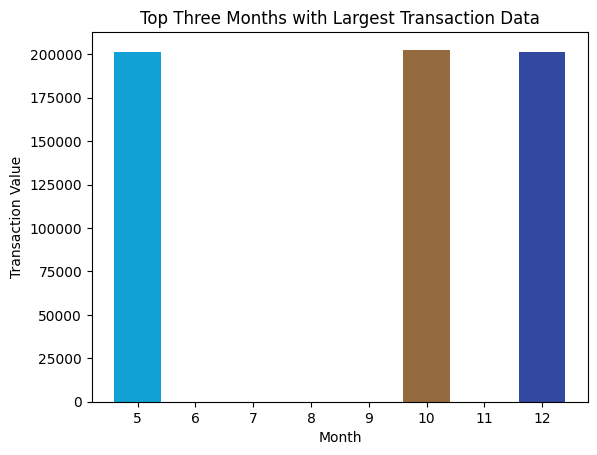

In [92]:

monthly_totals = df.groupby('MONTH') \
                                     .agg(F.sum('TRANSACTION_VALUE').alias('TOTAL_VALUE'))

top_three_months = monthly_totals.orderBy(F.desc('TOTAL_VALUE')).limit(3).toPandas()

months = top_three_months['MONTH']
totals = top_three_months['TOTAL_VALUE']

colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(3)]

plt.bar(months, totals, color=colors)
plt.xlabel('Month')
plt.ylabel('Transaction Value')
plt.title('Top Three Months with Largest Transaction Data')
plt.show()


### Print details about the dataFrame

In [93]:
print(f"rows: {df.count()}")
print(len(df.columns))
df.describe().show()
df.printSchema()
df.columns

rows: 46694
9
+-------+------------------+--------------------+-------------------+-----------------+------------------+------------------+----------------+------------------+--------------------+
|summary|       BRANCH_CODE|      CREDIT_CARD_NO|           CUST_SSN|              DAY|             MONTH|    TRANSACTION_ID|TRANSACTION_TYPE| TRANSACTION_VALUE|                YEAR|
+-------+------------------+--------------------+-------------------+-----------------+------------------+------------------+----------------+------------------+--------------------+
|  count|             46694|               46694|              46694|            46694|             46694|             46694|           46694|             46694|               46694|
|   mean| 75.00057823274939|4.210653353368964E15|1.234555184812824E8|14.50736711354778| 6.516875829871076|           23347.5|            null| 51.03938214759932|              2018.0|
| stddev|51.389074910957895|2.5604641248039957E7| 2561.2609103365367|8.

['BRANCH_CODE',
 'CREDIT_CARD_NO',
 'CUST_SSN',
 'DAY',
 'MONTH',
 'TRANSACTION_ID',
 'TRANSACTION_TYPE',
 'TRANSACTION_VALUE',
 'YEAR']

### Typecasting Datatypes

In [94]:
df = df.withColumn("BRANCH_CODE", col("BRANCH_CODE").cast(IntegerType()))
df = df.withColumn("CUST_SSN", col("CUST_SSN").cast(IntegerType()))
df = df.withColumn("TRANSACTION_ID", col("TRANSACTION_ID").cast(IntegerType()))
df = df.withColumn("TRANSACTION_VALUE", col("TRANSACTION_VALUE").cast(DoubleType()))

df.dtypes

[('BRANCH_CODE', 'int'),
 ('CREDIT_CARD_NO', 'string'),
 ('CUST_SSN', 'int'),
 ('DAY', 'bigint'),
 ('MONTH', 'bigint'),
 ('TRANSACTION_ID', 'int'),
 ('TRANSACTION_TYPE', 'string'),
 ('TRANSACTION_VALUE', 'double'),
 ('YEAR', 'bigint')]

### Convert DAY, MONTH, and YEAR into a TIMEID (YYYYMMDD)

In [95]:
df = df.withColumn("TIMEID", concat(df.YEAR.cast("string"), 
                                    lpad(df.MONTH.cast("string"), 2, "0"), 
                                    lpad(df.DAY.cast("string"), 2, "0")))
df.show()

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|20180320|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|20180708|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|20180419|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|20181010|
|        164|4210653349028689|123459988| 28|    5|             6|       Educatio

### Dropping Day, Month and Year to meet requirment

In [96]:
# df=df.drop("DAY")
# df=df.drop("MONTH")
# df=df.drop("YEAR")

### Renaming Column

In [97]:
df = df.withColumnRenamed("CREDIT_CARD_NO", "CUST_CC_NO")

### Display of the new DF

In [98]:
df.show()

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|20180320|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|20180708|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|20180419|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|20181010|
|        164|4210653349028689|123459988| 28|    5|             6|       Educatio

### Rearranging columns and assigning it a new variable

In [113]:
CDW_SAPP_CREDIT_CARD = df.select("CUST_CC_NO","TIMEID","CUST_SSN","BRANCH_CODE","TRANSACTION_TYPE","TRANSACTION_VALUE","TRANSACTION_ID","DAY","MONTH","YEAR")

### Displing the updated DF

In [114]:
CDW_SAPP_CREDIT_CARD.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+---+-----+----+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|DAY|MONTH|YEAR|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+---+-----+----+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1| 14|    2|2018|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2| 20|    3|2018|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|  8|    7|2018|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4| 19|    4|2018|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5| 10|   10|2018|
|4210653349028689|20180528|123459988|        164|       Education|             6

### Printing the datatype

In [108]:
CDW_SAPP_CREDIT_CARD.dtypes

[('CUST_CC_NO', 'string'),
 ('TIMEID', 'string'),
 ('CUST_SSN', 'int'),
 ('BRANCH_CODE', 'int'),
 ('TRANSACTION_TYPE', 'string'),
 ('TRANSACTION_VALUE', 'double'),
 ('TRANSACTION_ID', 'int'),
 ('YEAR', 'bigint')]

### Load data into MYSQL Database called creditcard_capstone

In [116]:
CDW_SAPP_CREDIT_CARD.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [ ]:
transaction_rates = CDW_SAPP_CREDIT_CARD.groupBy("TRANSACTION_TYPE").count().orderBy("count", ascending=False)
types = [row["TRANSACTION_TYPE"] for row in transaction_rates.collect()]
counts = [row["count"] for row in transaction_rates.collect()]

colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(3)]

plt.figure(figsize=(10, 6))
plt.barh(types, counts, color=colors)

plt.xlabel("Transaction Type")
plt.ylabel("Transaction Count")
plt.title("Transaction Rates by Transaction Type")
plt.show()


In [ ]:
branch_totals = CDW_SAPP_CREDIT_CARD \
    .filter(col('TRANSACTION_TYPE') == 'Healthcare') \
    .groupBy('BRANCH_CODE') \
    .agg({'TRANSACTION_VALUE': 'sum'}) \
    .withColumnRenamed('sum(TRANSACTION_VALUE)', 'total_value')

highest_branch = branch_totals \
    .orderBy(col('total_value').desc()) \
    .select('BRANCH_CODE') \
    .first()[0]

branch_totals_df = branch_totals.toPandas()

# Graph
plt.figure(figsize=(10, 6))
plt.bar(branch_totals_df['BRANCH_CODE'], branch_totals_df['total_value'], color='blue')

plt.xlabel('Branch Number')
plt.ylabel('Total Value of Healthcare Transactions')
plt.title('Total Dollar Value of Healthcare Transactions by Branch')
plt.show()
